In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from tensorflow.python.keras.utils.generic_utils import to_list

In [3]:
def resize(image, max_dim = 512):
    new_size = image.shape[:2]
    long_dim = tf.reduce_max(new_size).numpy()
    factor = max_dim / long_dim
    new_size *= factor
    new_size = tf.cast(new_size, tf.int32)
    return tf.cast(tf.image.resize(image, new_size), tf.uint8)

In [4]:
def load_image(path):
    image = Image.open(path)
    image = tf.constant(image)
    image = resize(image)
    image = image[tf.newaxis, :]
    return image

In [5]:
def imshow(image):
    if image.shape[0] == 1:
        image = image[0]
    plt.imshow(image)
    plt.axis('off')

In [7]:
content_image = load_image('cat.jpg')
style_image = load_image('picasso.jpg')

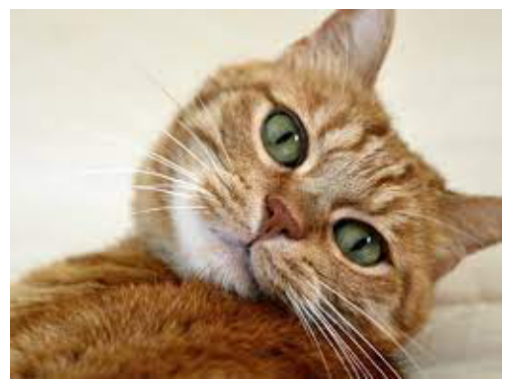

In [8]:
imshow(content_image)

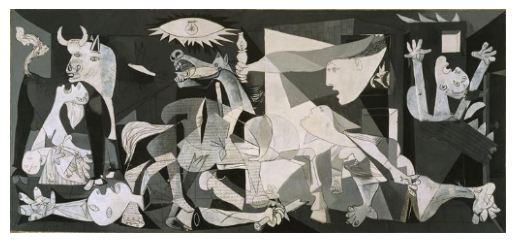

In [9]:
imshow(style_image)

In [10]:
def preprocess(image):
    image = tf.keras.applications.vgg19.preprocess_input(image)
    image = image / 255
    return image

In [11]:
content_image = preprocess(content_image)
style_image = preprocess(style_image)

In [12]:
vgg19 = tf.keras.applications.vgg19.VGG19(include_top = False, weights = "imagenet")

80134624/80134624 [==============================] - 3s 0us/step


In [13]:
for layer in vgg19.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  

In [15]:
def load_model(base_model, layers):
    inputs = base_model.input
    outputs = [base_model.get_layer(layer).output for layer in layers]
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
def gram_matrix(x):
    '''
    Input:
        x: tensor of shape (batch, height, width, channel)
    Output:
        gram_matrix of x of shape (batch, channel, channel)
    '''
    result = tf.einsum('bhwi,bhwj->bij', x, x)
    result = result / x.shape[1] / x.shape[2]
    return result

In [17]:
content_extractor = load_model(vgg19, content_layers)
style_extractor = load_model(vgg19, style_layers)

In [18]:
content = to_list(content_extractor(content_image))
style = [gram_matrix(x) for x in style_extractor(style_image)]

In [19]:
def generate_white_noise_image(shape):
    return tf.experimental.numpy.random.randint(0, 256, shape)

In [20]:
image = tf.Variable(tf.cast(load_image('cat.jpg'), dtype=tf.float32))
image.assign(image / 255)

<tf.Variable 'UnreadVariable' shape=(1, 385, 512, 3) dtype=float32, numpy=
array([[[[0.8784314 , 0.8666667 , 0.8       ],
         [0.8784314 , 0.8666667 , 0.8       ],
         [0.8784314 , 0.8666667 , 0.8       ],
         ...,
         [0.8392157 , 0.827451  , 0.7607843 ],
         [0.8392157 , 0.827451  , 0.7607843 ],
         [0.8392157 , 0.827451  , 0.7607843 ]],

        [[0.8784314 , 0.8666667 , 0.8       ],
         [0.8784314 , 0.8666667 , 0.8       ],
         [0.8784314 , 0.8666667 , 0.8       ],
         ...,
         [0.8392157 , 0.827451  , 0.7607843 ],
         [0.8392157 , 0.827451  , 0.7607843 ],
         [0.8392157 , 0.827451  , 0.7607843 ]],

        [[0.8784314 , 0.8666667 , 0.8       ],
         [0.8784314 , 0.8666667 , 0.8       ],
         [0.8784314 , 0.8666667 , 0.8       ],
         ...,
         [0.8392157 , 0.827451  , 0.7607843 ],
         [0.8392157 , 0.827451  , 0.7607843 ],
         [0.8392157 , 0.827451  , 0.7607843 ]],

        ...,

        [[0.55294

In [21]:
def loss_function(outputs, content, style, alpha, beta):
    image_content = outputs["content"]
    image_style = outputs["style"]

    content_loss = tf.add_n([tf.reduce_mean(tf.square(F - P)) for F, P in zip(image_content, content)])
    content_loss = content_loss / len(content)

    style_loss = tf.add_n([tf.reduce_mean(tf.square(G - A)) for G, A in zip(image_style, style)])
    style_loss = style_loss / len(style)

    total_loss = alpha * content_loss + beta * style_loss
    return total_loss

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.90, epsilon=1e-1)

In [32]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        image_content = to_list(content_extractor(image))
        image_style = [gram_matrix(x) for x in style_extractor(image)]
        outputs = {'content': image_content, 'style': image_style}
        loss = loss_function(outputs, content, style, 1, 10**4)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

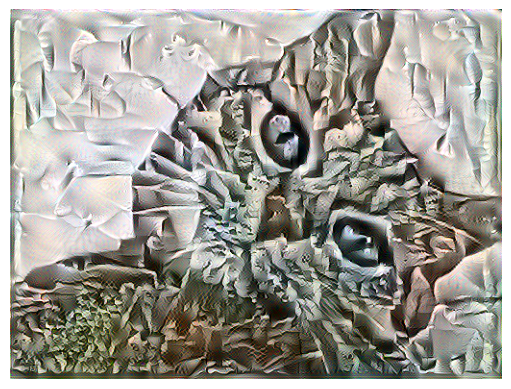

In [ ]:
steps = 1000
for step in range(steps):
    train_step(image)
imshow(image)